# Qualitative Evaluation for the VAE model

In [2]:
import torch
import torchgadgets as tg
import os
from pathlib import Path as P
import numpy as np
import utils
from models import ConvVAE, get_resnet_vae
from tbparse import SummaryReader
from matplotlib.gridspec import GridSpec 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


from tqdm import tqdm

import matplotlib.pyplot as plt

from torchsummary import summary


## Model Information

In [3]:
exp_name = 'resnet_vae'
run_name = 'run_1'
checkpoint = 50

log_dir = P(os.getcwd(), 'experiments', exp_name, run_name, 'logs')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Model/Data Loading

In [4]:
# Load the config files
load_augm_config_train = utils.load_config('augm_train_preLoad') 
load_augm_config_test = utils.load_config('augm_test_preLoad')

config = utils.load_config_from_run(exp_name, run_name)
config['num_iterations'] = config['dataset']['train_size'] // config['batch_size']

tg.tools.set_random_seed(config['random_seed'])
##-- Load Dataset --##
# Simply load the dataset using TorchGadgets and define our dataset to apply the initial augmentations
data = tg.data.load_dataset('food101')
train_dataset = data['train_dataset']
test_dataset = data['test_dataset']
train_dataset = tg.data.ImageDataset(dataset=train_dataset, transforms=load_augm_config_train)
test_dataset = tg.data.ImageDataset(dataset=test_dataset, transforms=load_augm_config_test, train_set=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True, num_workers=2)

##-- Load Model from Checkpoint --##
if config['model']['type'] in ['vae', 'cond_vae']:
            model = ConvVAE(config['model'])
if config['model']['type'] == 'resnet_vae':
    model = get_resnet_vae(config['model'])
model.eval()
utils.load_model_from_checkpoint(exp_name, run_name, model, checkpoint)
criterion = tg.training.ReconKLDivLoss(lambda_kld=0.002)


##-- Data Augmentor --##
data_augmentor = tg.data.ImageDataAugmentor(config=config['pre_processing'])


categories = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari',
    'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad',
    'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza',
    'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus',
    'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',
    'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings',
    'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck',
    'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich',
    'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi',
    'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese',
    'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake',
    'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'
]


Model checkpoint was load from: /home/user/denninge/VisionLabSS23/Assignments_6/experiments/resnet_vae/run_1/checkpoints/checkpoint_50.pth


In [5]:

##-- Load TensorBoard Logs --##
reader = SummaryReader(log_dir, pivot=True)
train_data = reader.scalars

train_loss = train_data.loc[:,'iteration_metrics/train_loss'].to_numpy().astype(float)
train_mse= train_data.loc[:,'iteration_metrics/mse'].to_numpy().astype(float)
train_kld = train_data.loc[:,'iteration_metrics/kld'].to_numpy().astype(float)

eval_loss = train_data.loc[:,'epoch_metrics/eval_loss'].to_numpy().astype(float)
eval_mse= np.array(train_data.loc[:,'epoch_metrics/mse'][0])
eval_kld = np.array(train_data.loc[:,'epoch_metrics/kld'][0])

train_loss = train_loss[~np.isnan(train_loss)]
eval_loss = eval_loss[~np.isnan(eval_loss)]
train_mse = train_mse[~np.isnan(train_mse)]
eval_mse = eval_mse[~np.isnan(eval_mse)]
train_kld = train_kld[~np.isnan(train_kld)]
eval_kld = eval_kld[~np.isnan(eval_kld)]


## Model Architecture

In [6]:
print(model)
summary(model.to('cuda'), (3,64,64))

BaseVAE(
  (encoder): ResNet(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, 

## Training Progress

Text(0.5, 1.0, 'Training/Evaluation Losses')

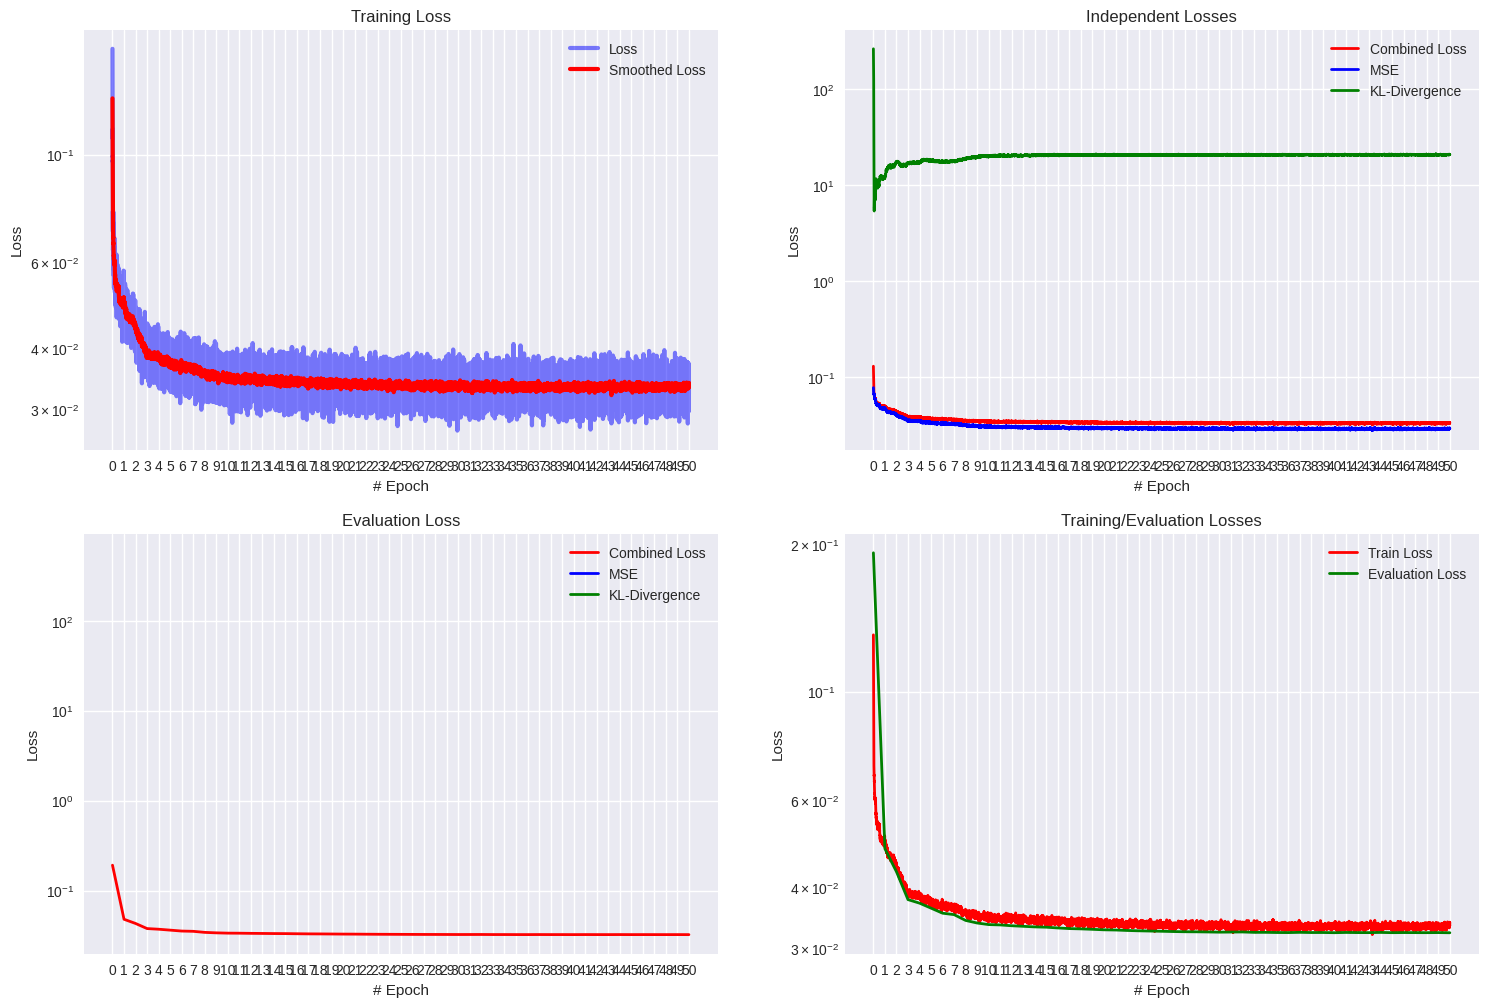

In [7]:
plt.style.use('seaborn-v0_8')

x_ticks_pos = np.arange(0, config['num_iterations']*(config['num_epochs']+1), config['num_iterations'])
x_ticks = np.arange(0,config['num_epochs']+1)

fig, ax = plt.subplots(2,2, figsize=(18,12))

smooth_loss = tg.visualization.smooth_curve(train_loss, K=31)
smooth_mse = tg.visualization.smooth_curve(train_mse, K=31)
smooth_kld = tg.visualization.smooth_curve(train_kld, K=31)

ax[0,0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0,0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0,0].set_xticks(x_ticks_pos, x_ticks)
ax[0,0].legend(loc="best")
ax[0,0].set_xlabel("# Epoch")
ax[0,0].set_ylabel("Loss")
ax[0,0].set_yscale("log")
ax[0,0].set_title("Training Loss")

ax[0,1].plot(smooth_loss, c="red", label="Combined Loss", linewidth=2, alpha=1)
ax[0,1].plot(smooth_mse, c="blue", label="MSE", linewidth=2, alpha=1)
ax[0,1].plot(smooth_kld, c="green", label="KL-Divergence", linewidth=2, alpha=1)
ax[0,1].set_xticks(x_ticks_pos, x_ticks)
ax[0,1].legend(loc="best")
ax[0,1].set_xlabel("# Epoch")
ax[0,1].set_ylabel("Loss")
ax[0,1].set_yscale("log")
ax[0,1].set_title("Independent Losses")

ax[1,0].plot(eval_loss, c="red", label="Combined Loss", linewidth=2, alpha=1)
ax[1,0].plot(eval_mse, c="blue", label="MSE", linewidth=2, alpha=1)
ax[1,0].plot(eval_kld, c="green", label="KL-Divergence", linewidth=2, alpha=1)
ax[1,0].set_xticks(x_ticks)
ax[1,0].legend(loc="best")
ax[1,0].set_xlabel("# Epoch")
ax[1,0].set_ylabel("Loss")
ax[1,0].set_yscale("log")
ax[1,0].set_title("Evaluation Loss")

ax[1,1].plot(smooth_loss, c="red", label="Train Loss", linewidth=2, alpha=1)
ax[1,1].plot(x_ticks_pos, eval_loss, c="green", label="Evaluation Loss", linewidth=2, alpha=1)
ax[1,1].set_xticks(x_ticks_pos, x_ticks)
ax[1,1].legend(loc="best")
ax[1,1].set_xlabel("# Epoch")
ax[1,1].set_ylabel("Loss")
ax[1,1].set_yscale("log")
ax[1,1].set_title("Training/Evaluation Losses")


# Evaluation Run

In [8]:
num_keep = 100
num_iterations = 40

model = model.to(device)
model.eval()
eval_imgs, eval_output, eval_latents, eval_labels = [], [], [], []
progress_bar = tqdm(enumerate(train_loader), total=config['dataset']['test_size']//config['batch_size'])
with torch.no_grad():
    for i, (imgs, lbls) in progress_bar:
        if i==num_iterations:
            break
        imgs = imgs.to(device)
        output, (z, mu, sigma) = model(imgs)
        loss, (mse, kld) = criterion(output.float(), imgs.float(), mu, sigma)
        progress_bar.set_description(f'Loss (mse/kld): {loss.cpu().item():.4f} ({mse.cpu().item():.4f}/{kld.cpu().item():.4f})')

        if i<num_keep:
            eval_imgs.append(imgs.cpu())
            eval_output.append(output.cpu())
            eval_latents.append(z.cpu())
            eval_labels.append(lbls)

model = model.to('cpu')

Loss (mse/kld): 0.0693 (0.0275/20.8976):  10%|█         | 40/394 [00:18<02:43,  2.17it/s]


## Reconstruction Samples

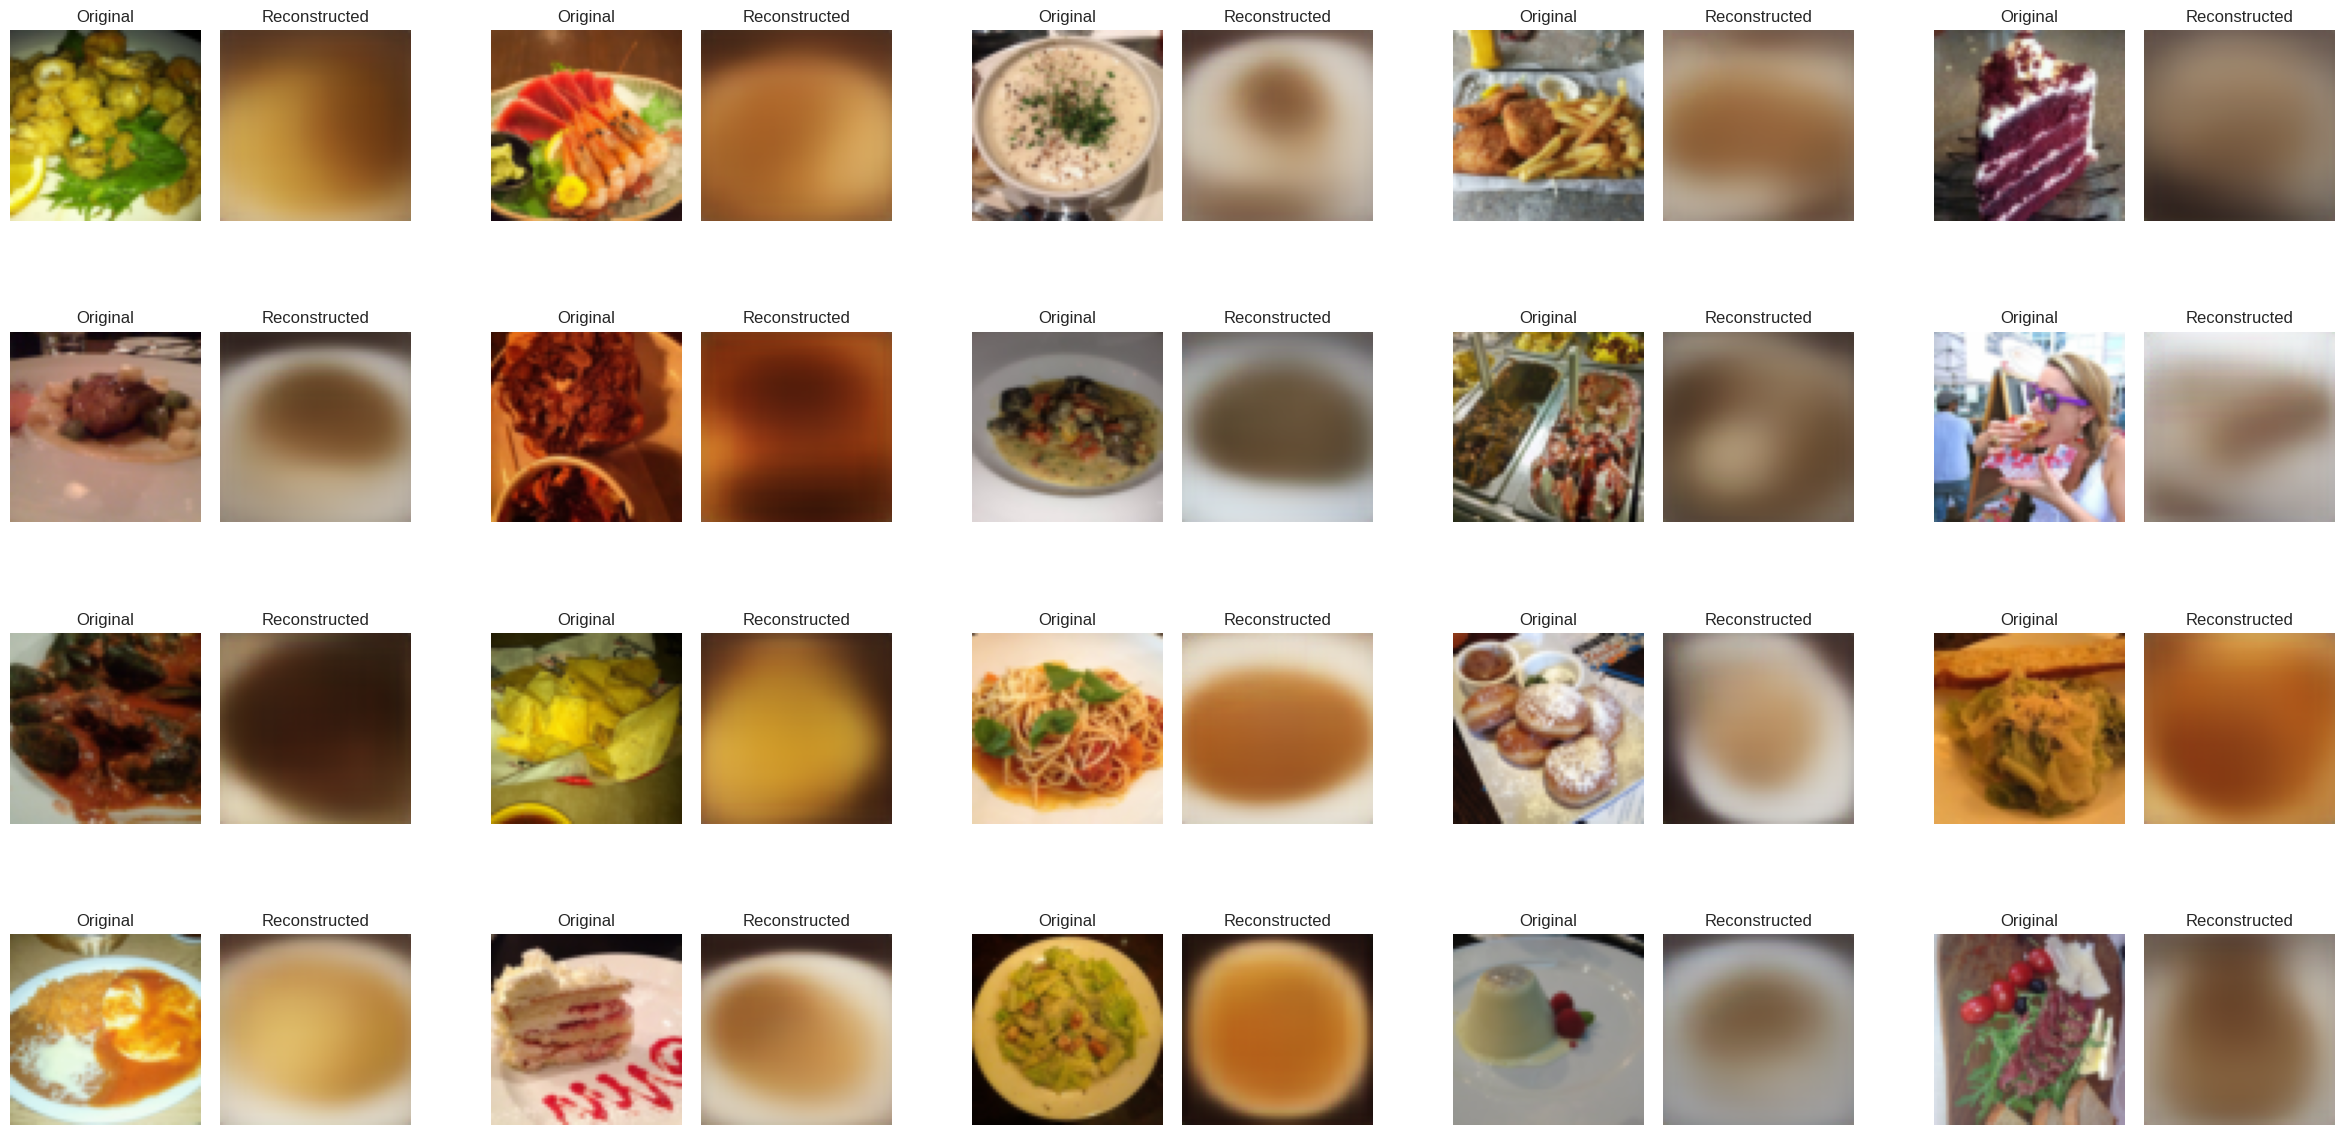

In [9]:
img, output, label = eval_imgs[0], eval_output[0], eval_labels[0]


# Visualize images and their reconstruction
layout = (4,5)
num_imgs = layout[0]*layout[1]
fig = plt.figure(figsize=(30,15))

figure_grid = GridSpec(layout[0], layout[1], figure=fig)

img_ind = 0
for x in range(layout[0]):
    for y in range(layout[1]):
        img_plot = figure_grid[x,y].subgridspec(1,2, wspace=0.1, hspace=0.0)
        ax = fig.add_subplot(img_plot[0])
        ax.imshow(img[img_ind].permute((1,2,0)))
        ax.axis('off')
        ax.set_title('Original')
        ax = fig.add_subplot(img_plot[1])
        ax.imshow(output[img_ind].permute((1,2,0)))
        ax.axis('off')
        ax.set_title('Reconstructed')
        img_ind += 1

fig.show()

## Analysis of the Latent Space

### Visualization Latent Space

In [10]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)])

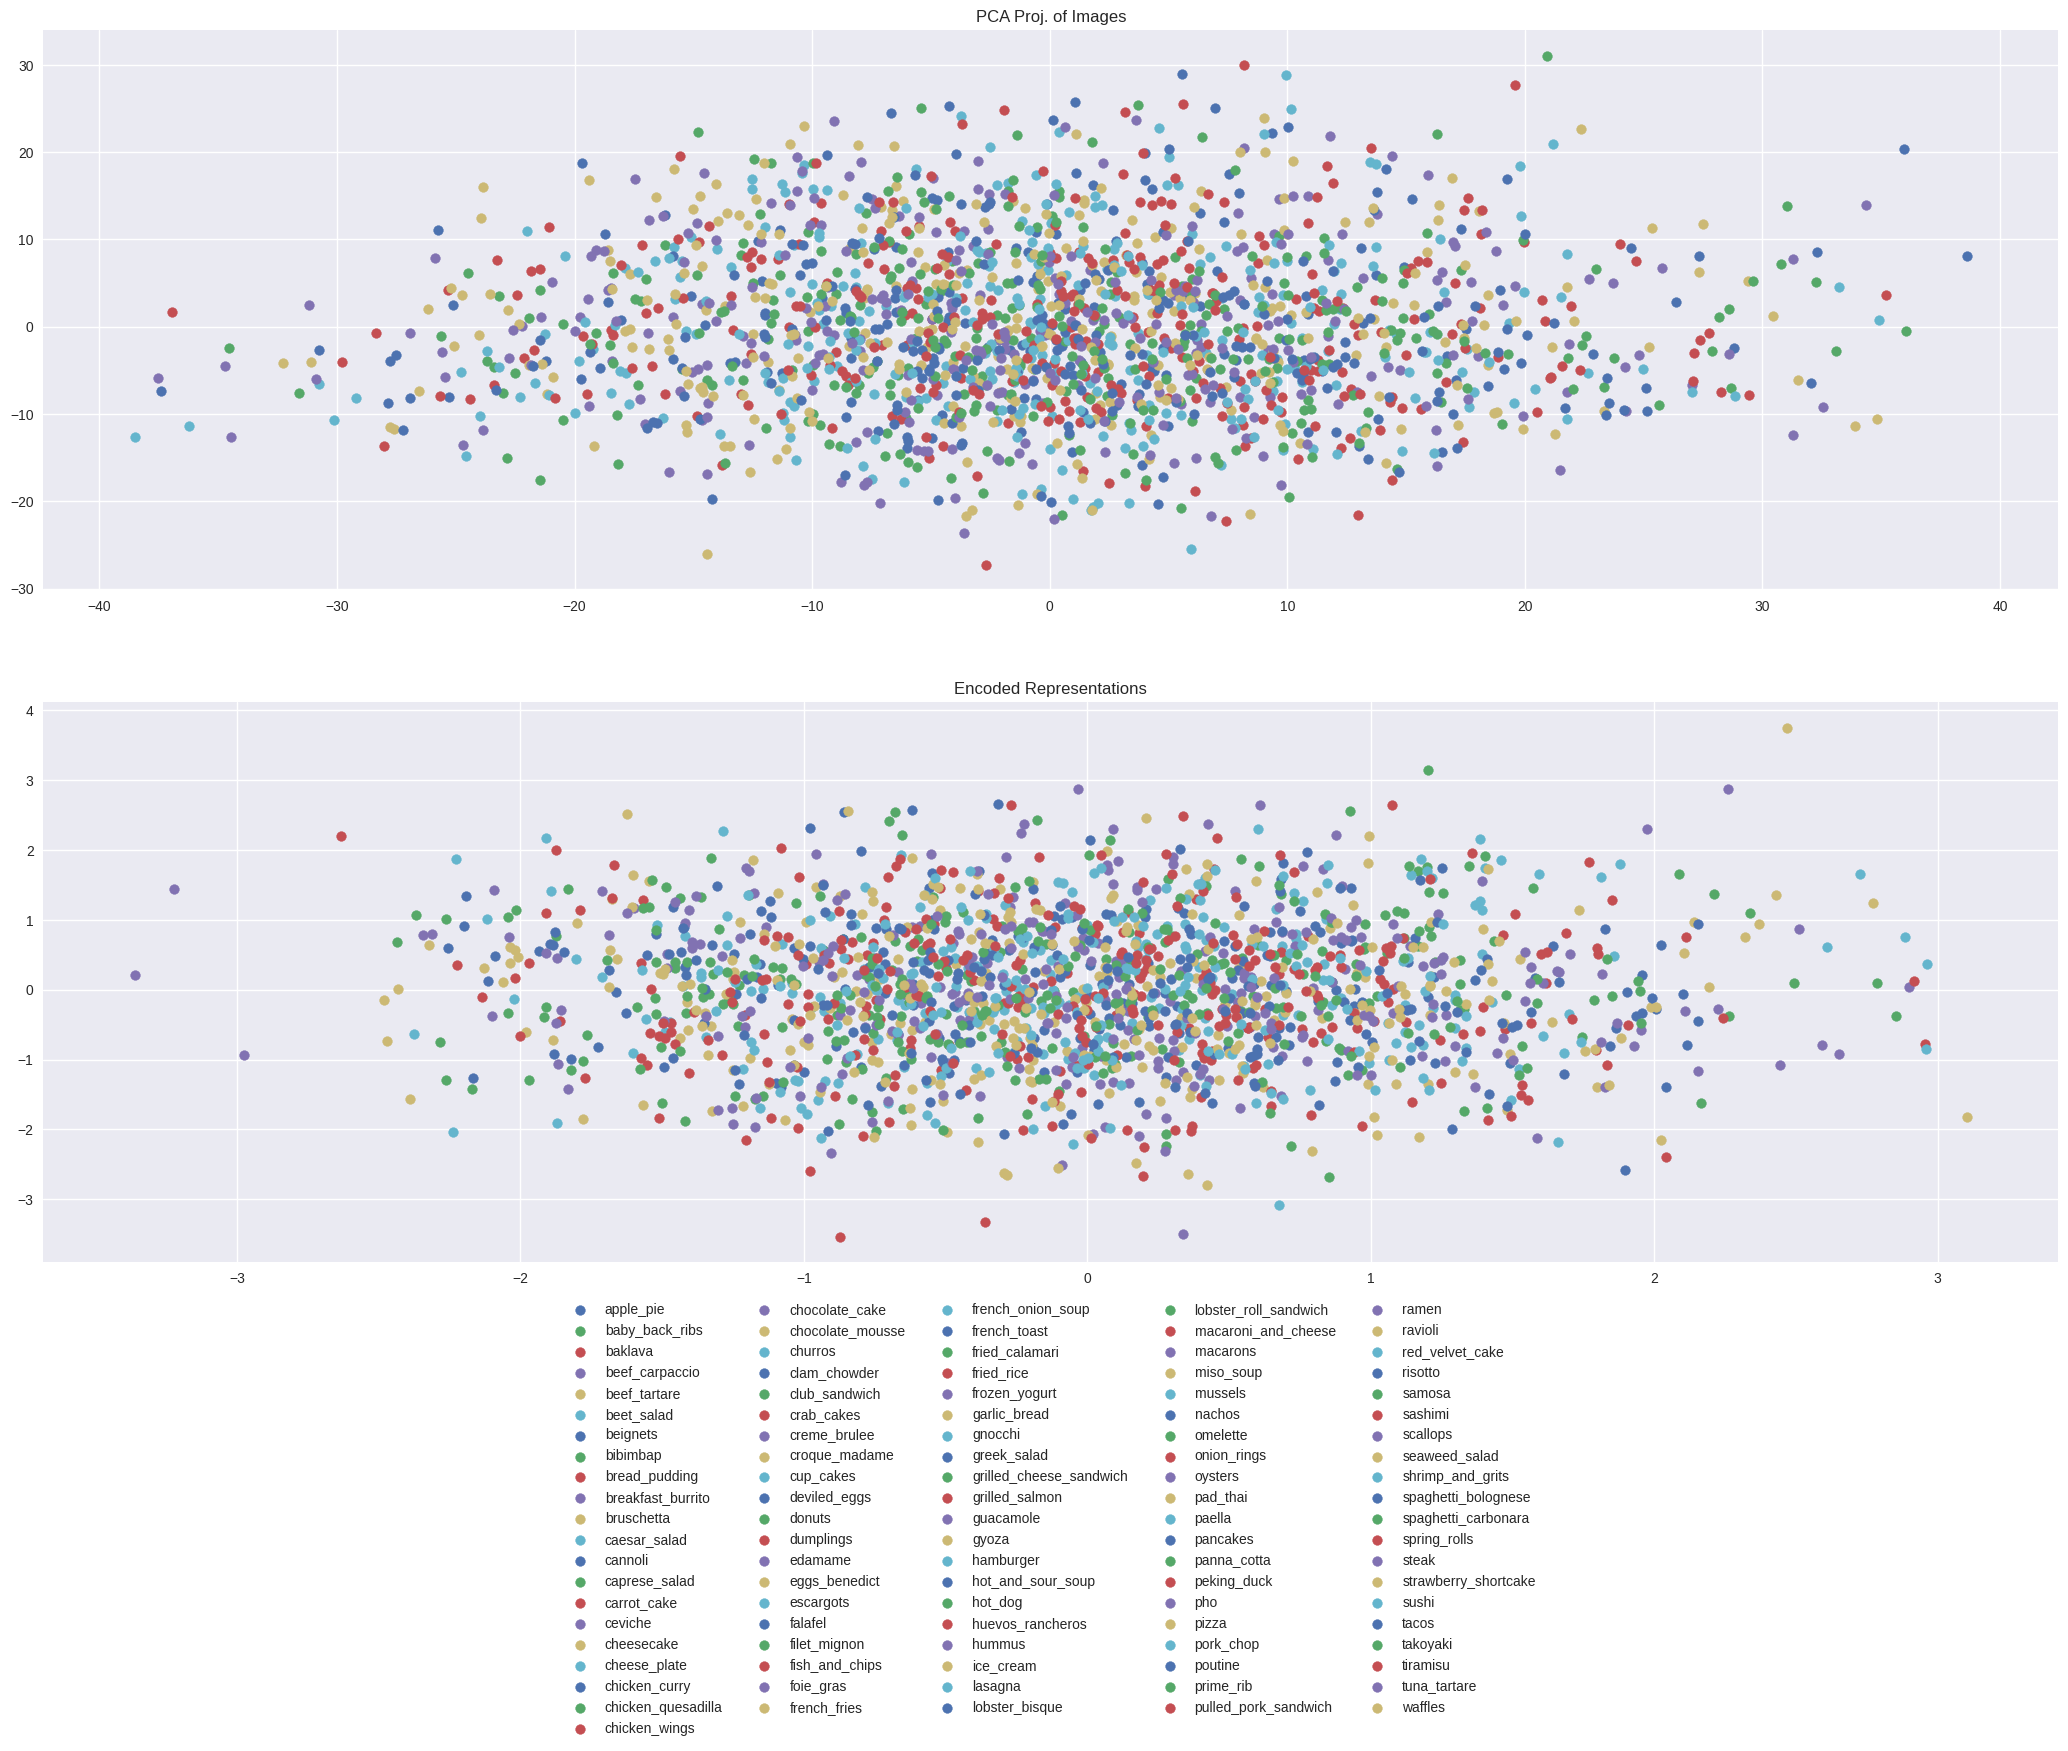

In [11]:
# Parameters
num_display = 2000

eval_imgs = np.concatenate([img.view(imgs.shape[0],-1) for img in eval_imgs])
eval_latents = np.concatenate(eval_latents)
eval_labels = np.concatenate(eval_labels)

pca_imgs = PCA(n_components=2).fit_transform(eval_imgs)

# N = 2000
fig,ax = plt.subplots(2,1,figsize=(26,16))
display_projections(pca_imgs[:num_display], eval_labels[:num_display], ax=ax[0], legend=categories)
ax[0].set_title("PCA Proj. of Images")
display_projections(eval_latents[:num_display], eval_labels[:num_display], ax=ax[1], legend=categories)
ax[1].set_title("Encoded Representations")
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

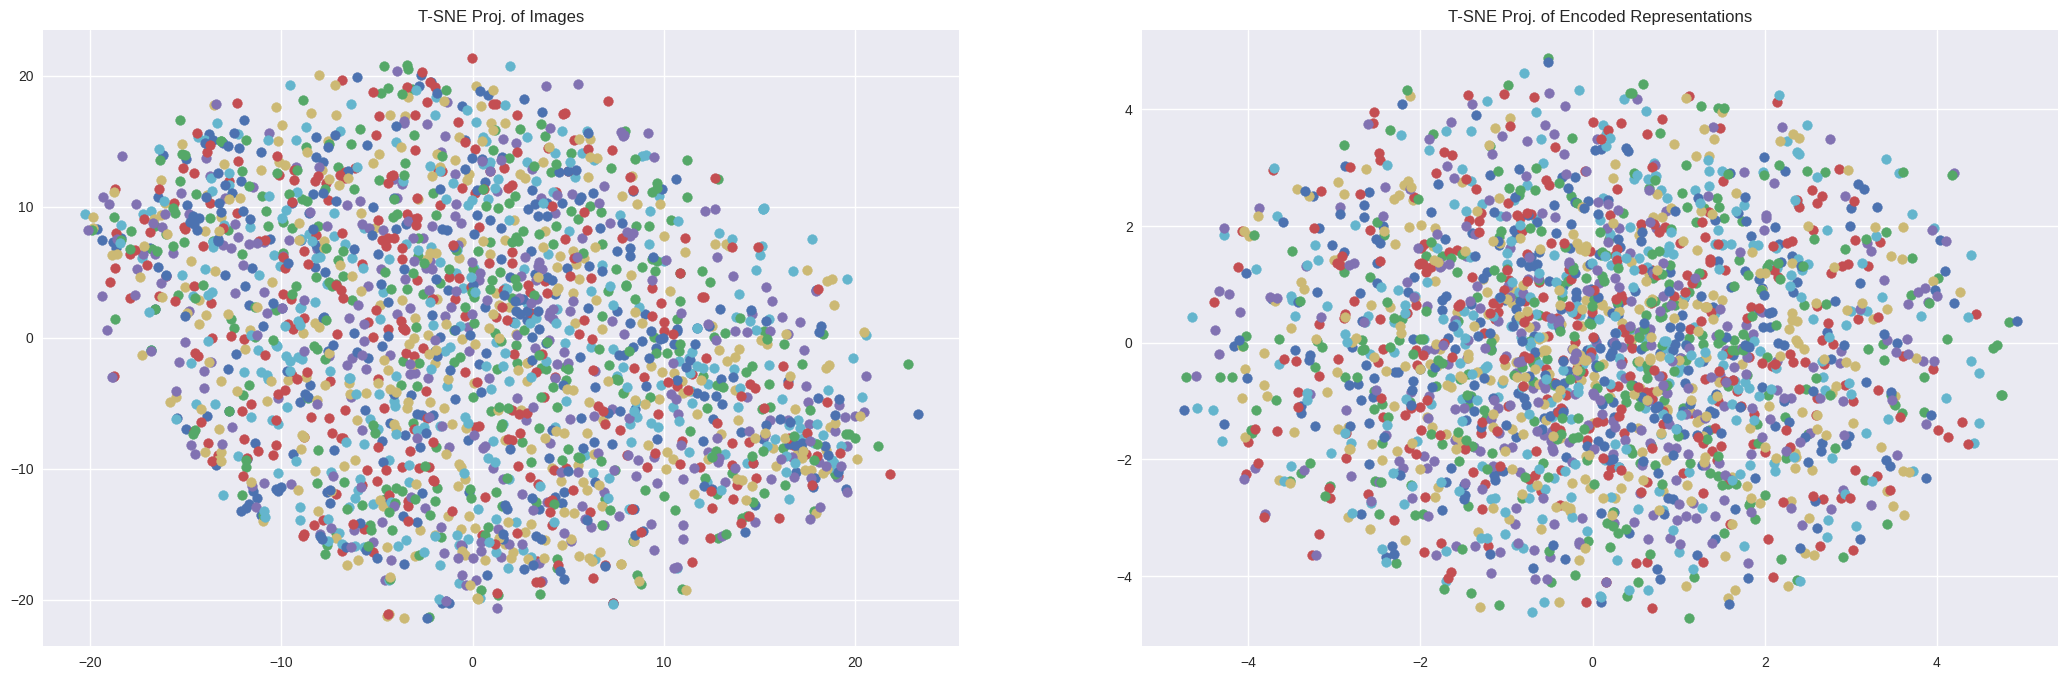

In [12]:
tsne_imgs = TSNE(n_components=2).fit_transform(eval_imgs[:num_display])
tsne_latents = TSNE(n_components=2).fit_transform(eval_latents[:num_display])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:num_display], eval_labels[:num_display], ax=ax[0], legend=categories)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:num_display], eval_labels[:num_display], ax=ax[1], legend=categories)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()



### Interpolation over Latent Space

In [13]:

@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")


In [14]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=20)

NotImplementedError: Input Error: Only 3D, 4D and 5D input Tensors supported (got 2D) for the modes: nearest | linear | bilinear | bicubic | trilinear | area | nearest-exact (got bilinear)

## Garbage Collection

In [ ]:
del train_loss, eval_loss, train_mse, eval_mse, train_kld, eval_kld

del eval_output, eval_labels, eval_latents, eval_imgs